In [1]:
!pip install jax jaxlib

# State Estimation in the Budyko-Sellers energy balance model using algorithmic differentiation in JAX

This notebook runs the Budyko-Sellers 1-D energy balance model and uses its gradient to reduce the cost function J, which represents the mismatch between zonal mean temperature from NCEP and the model. 

<font color='blue'>__[Notes on the Budyko-Sellers Model](https://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/Lectures/Lecture14%20--%20Diffusive%20energy%20balance%20model.html)__</font>

<font color='blue'>__[Notes on L-BFGS implementation](https://medium.com/gaussian-machine/implement-l-bfgs-optimization-from-scratch-3e5c909f9079)__</font>


In [2]:
import jax.numpy as jnp
from jax import grad

import numpy as np
import jax.numpy as jnp
from jax import grad, lax,jit
import sys
N = 100
num_controls = 1
import netCDF4 as nc
import matplotlib.pyplot as plt
from collections import deque

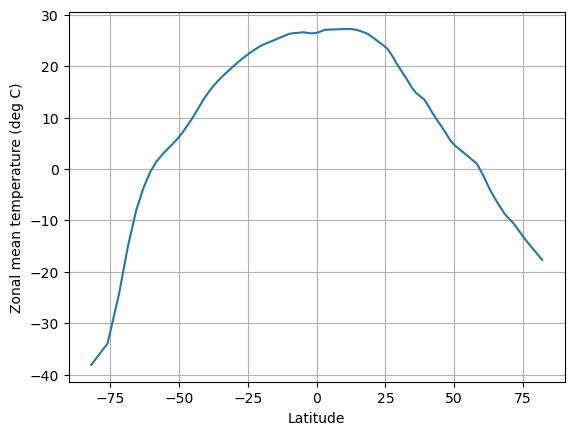

In [62]:
## Import NCEP temperature, get zonal mean and extrapolate to grid size

XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
LAT = jnp.arcsin(X) * 180.0 / jnp.pi
DX = X[1] - X[0]

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_Ts = nc.Dataset( ncep_url + "surface_gauss/skt.sfc.mon.1981-2010.ltm.nc" )
lat_ncep = ncep_Ts.variables['lat']; lon_ncep = ncep_Ts.variables['lon']
Ts_ncep_annual = np.mean(ncep_Ts.variables['skt'][:], axis=(0,2) )
Ts_annual_interp = np.interp(LAT,np.array(lat_ncep[::-1]),Ts_ncep_annual[::-1])
plt.plot(LAT,jnp.array(Ts_annual_interp))
plt.xlabel('Latitude')
plt.ylabel('Zonal mean temperature (deg C)')
plt.grid()

In [4]:

def budyko_sellers_jax(XXS):
    MAX_ITER = 100000  # Reduce if needed for speed

    # Load target temperatures and convert to jax array
    #TARGET_DT = jnp.array(np.loadtxt('T_zonalmean_NCEP.dat'))
    TARGET_DT = jnp.array(Ts_annual_interp)
    # Constants
    S0 = 1366.0
    Q = S0 / 4.0
    SIGMA = 5.67e-8
    EPSILON = 0.63
    DIFF = 0.6

    XEDGES = jnp.linspace(-1.0, 1.0, N + 1)
    X = 0.5 * (XEDGES[:-1] + XEDGES[1:])
    LAT = jnp.arcsin(X) * 180.0 / jnp.pi
    DX = X[1] - X[0]

    SX = Q * (1.0 - 0.482 * X**2) * 1.35 - 55.0

    # Initial temperature
    T_init = 288.0 + 60.0 * (1.0 - X**2) - 20.0

    DT = DX**2 / (2.0 * (DIFF)) * 0.5
    alpha0 = 0.354
    alpha2 = 0.25
    def step(_,state):
        T, XXS = state['T'], state['XXS']
        ALPHA = alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)
        ALPHA = jnp.log(ALPHA / (1.0 - ALPHA)) + XXS
        ALPHA = 1.0 / (1.0 + jnp.exp(-ALPHA))

        emiss_logit = jnp.log(EPSILON/(1.0-EPSILON)) 
        emiss = 1.0/(1.0+ jnp.exp(-emiss_logit))

        FIN = SX * (1.0 - ALPHA)
        FOUT = (emiss) * SIGMA * T**4

        DTDX_M = jnp.concatenate([jnp.array([0.0]), (T[1:] - T[:-1]) / DX])
        DTDX_P = jnp.concatenate([(T[1:] - T[:-1]) / DX, jnp.array([0.0])])

        FDIFF = (DIFF ) * ((1 - XEDGES[1:]**2) * DTDX_P -
                        (1 - XEDGES[:-1]**2) * DTDX_M) / DX

        T_new = T + DT * (FIN - FOUT + FDIFF)
        return {'T': T_new, 'XXS': XXS}
    init_state = {'T': T_init, 'XXS': XXS}
    state_final = lax.fori_loop(0, MAX_ITER, step, init_state)
    T_final,XXS = state_final['T'],state_final['XXS']
    alpha_raw =  alpha0 + alpha2 * (1.5 * jnp.sin(jnp.radians(LAT))**2 - 0.5)
    logits = jnp.log(alpha_raw / (1.0 - alpha_raw)) + XXS
    ALPHA = 1.0 / (1.0 + jnp.exp(-logits))
    emiss_logit = jnp.log(EPSILON/(1.0-EPSILON))
    emiss = 1.0/(1.0+ jnp.exp(-emiss_logit))
    # Cost: L2 norm between T_final and TARGET_DT (converted from K to C)
    J = jnp.sqrt(jnp.sum((T_final - TARGET_DT - 273.0)**2)) / N
    return J,T_final,ALPHA,emiss

def cost_fxn(XXS):
    J,_,_,_ = budyko_sellers_jax(XXS)
    return J

In [5]:
from jax import grad

grad_J = grad(cost_fxn)

XXS = jnp.zeros(N*num_controls)
dJ_dXXS = grad_J(XXS) 

In [63]:
## gradient descent
XXS = jnp.zeros(N*num_controls)
a = 1
max_iter = 300
J = 1000
i = 0
Js_sd = np.zeros(max_iter)
while((J > 0) & (i < max_iter)):
    J,T,alpha,emiss = budyko_sellers_jax(XXS)
    g = grad_J(XXS)
    print(f'Cost function at step {i}: {J}')
    XXS = XXS - a*g
    Js_sd[i] = J
    i = i+1
T_sd = T
D_sd = 0.6 + XXS[:N]
alpha_sd = alpha
eps_sd = emiss

Cost function at step 0: 0.901994526386261
Cost function at step 1: 0.8654133677482605
Cost function at step 2: 0.8307064771652222
Cost function at step 3: 0.7978968024253845
Cost function at step 4: 0.766935408115387
Cost function at step 5: 0.7377644181251526
Cost function at step 6: 0.7104030847549438
Cost function at step 7: 0.6847699880599976
Cost function at step 8: 0.6609514355659485
Cost function at step 9: 0.6387990117073059
Cost function at step 10: 0.6182180643081665
Cost function at step 11: 0.599292516708374
Cost function at step 12: 0.581866443157196
Cost function at step 13: 0.5658971667289734
Cost function at step 14: 0.5513197183609009
Cost function at step 15: 0.5379676222801208
Cost function at step 16: 0.5258986949920654
Cost function at step 17: 0.5148789882659912
Cost function at step 18: 0.504879355430603
Cost function at step 19: 0.4958551526069641
Cost function at step 20: 0.4876764714717865
Cost function at step 21: 0.48025646805763245
Cost function at step 22

In [26]:
def backtracking_line_search(x, J, g, d, a0=1.0, c=1e-4, tau=0.5, max_iter=20):
    """
    x   : current point
    J   : current cost at x
    g   : current gradient at x
    d   : search direction
    fxn : function that returns cost given x
    a0  : initial step size
    c   : Armijo parameter
    tau : step size reduction factor
    """
    a = a0
    for _ in range(max_iter):
        x_new = x + a * d
        J_new = cost_fxn(x_new)

        # Armijo (sufficient decrease) condition
        if J_new <= J + c * a * jnp.dot(g, d):
            return a  # condition satisfied
        a *= tau  # reduce step size

    return None  # return last step size even if condition not satisfied

In [68]:
# BFGS Algorithm
XXS = jnp.zeros(N*num_controls)
a = 1e-4
max_i = 300
i = 0
B = jnp.identity(N*num_controls)
J_bfgs = []

J_prev,T_prev,alpha,emiss = budyko_sellers_jax(XXS)
g_prev = grad_J(XXS)
XXS_prev = XXS
print(f'Cost function at step 1: {J_prev}')

XXS = XXS - a*g_prev


for i in range(max_i):
    
    J,T,alpha,emiss = budyko_sellers_jax(XXS)
    print(f'Cost function at step {i+2}: {J}')
    g = grad_J(XXS)

    y = g - g_prev
    #if np.linalg.norm(s) <1e-7:
        #break
    s = XXS - XXS_prev
    rho = 1/(jnp.dot(y.T,s) + 1e-4)
    

    B = B.dot(np.identity(N*num_controls)-rho * jnp.outer(s,y)) + \
        rho *jnp.outer(s,s.T)
   # print(np.linalg.norm(B))

    B = (np.identity(N*num_controls) - rho * jnp.outer(y,s).T) @ (B)

    

    J_bfgs.append(J)
    g_prev = g
    XXS_prev = XXS
    T_prev = T
    alpha_prev = alpha
    emiss_prev = emiss
    d = B.dot(g)
    a = backtracking_line_search(XXS,J,g,d,a0=1)
    if (a is None) or (np.allclose(g,np.zeros(N*num_controls),rtol=1e-5)) \
        or (J_prev - J < 1e-6):
        print('BFGS optimization complete')
        break
    XXS = XXS - d
    J_prev = J
    print(f'a={a}')


T_bfgs = T
D_bfgs = 0.6 + XXS[:N]
alpha_bfgs = alpha
eps_bfgs = emiss


Cost function at step 1: 0.901994526386261
Cost function at step 2: 0.9019920229911804
a=1.52587890625e-05
Cost function at step 3: 0.8654109835624695
a=7.62939453125e-06
Cost function at step 4: 0.7522380352020264
a=0.0001220703125
Cost function at step 5: 0.743457555770874
a=1.9073486328125e-06
Cost function at step 6: 0.541968047618866
a=0.000244140625
Cost function at step 7: 0.5410646200180054
a=3.814697265625e-06
Cost function at step 8: 0.532314658164978
a=9.5367431640625e-07
Cost function at step 9: 0.42706528306007385
a=0.015625
Cost function at step 10: 0.4263801574707031
a=0.001953125
Cost function at step 11: 0.42482322454452515
a=0.000244140625
Cost function at step 12: 0.42195308208465576
a=7.62939453125e-06
Cost function at step 13: 0.39318645000457764
a=1.9073486328125e-06
Cost function at step 14: 0.38928043842315674
a=0.0001220703125
Cost function at step 15: 0.38707101345062256
a=7.62939453125e-06
Cost function at step 16: 0.3661181926727295
a=6.103515625e-05
Cost fu

In [75]:
# Limited memory BFGS (L-BFGS): use only last k derivatives
k = 10
s_list = deque(maxlen=k)
y_list = deque(maxlen=k)
rho_list = deque(maxlen=k)
XXS = jnp.zeros(N*num_controls)
max_i = 300
g = grad_J(XXS)
a = 1e-5
J_lbfgs = []
for i in range(max_i):
    
    J, T, alpha, emiss = budyko_sellers_jax(XXS)
    print(f'Cost at step {i+1}: {J:.6f}')
    
    q = g
    alpha_list = []

    # First loop: compute intermediate q
    for s, y, rho in reversed(list(zip(s_list, y_list, rho_list))):
        alpha_i = rho * jnp.dot(s, q)
        alpha_list.append(alpha_i)
        q = q - alpha_i * y

    # Scaling of initial Hessian approximation (identity)
    if len(s_list) > 110:
        gamma = jnp.dot(s_list[-1], y_list[-1]) / jnp.dot(y_list[-1], y_list[-1])
    else:
        gamma = 1.0
    r = gamma * q

    # Second loop: compute direction
    for (s, y, rho, alpha_i) in zip(s_list, y_list, rho_list, reversed(alpha_list)):
        beta = rho * jnp.dot(y, r)
        r = r + s * (alpha_i - beta)

    # Descent direction
    d = -r

    # Step
    a = backtracking_line_search(XXS,J,g,d,a0=1.1)
    if i >1 and ((a is None) or (np.allclose(g,np.zeros(N*num_controls)))): 
        print('L-BFGS optimization complete')
        break
    XXS_new = XXS + a * d

    g_new = grad_J(XXS_new)
    # Update s, y, rho
    s = XXS_new - XXS
    y = g_new - g
    rho = 1.0 / (jnp.dot(y, s) + 1e-6)  

    if (J==J) and jnp.dot(y, s) > 1e-10:  # Check curvature condition
         s_list.append(s)
         y_list.append(y)
         rho_list.append(rho)
    else:
         break
    # Update variables
    XXS = XXS_new
    g = g_new
    J_lbfgs.append(J)

T_lbfgs = T
D_lbfgs = 0.6 + XXS[:N]
alpha_lbfgs = alpha
eps_lbfgs = emiss


Cost at step 1: 0.901995
Cost at step 2: 0.861791
Cost at step 3: 0.768226
Cost at step 4: 0.481744
Cost at step 5: 0.444677
Cost at step 6: 0.441815
Cost at step 7: 0.431697
Cost at step 8: 0.405948
Cost at step 9: 0.377780
Cost at step 10: 0.355351
Cost at step 11: 0.348498
Cost at step 12: 0.346882
Cost at step 13: 0.336988
Cost at step 14: 0.329446
Cost at step 15: 0.321704
Cost at step 16: 0.320038
Cost at step 17: 0.317167
Cost at step 18: 0.310860
Cost at step 19: 0.296589
Cost at step 20: 0.278391
Cost at step 21: 0.274869
Cost at step 22: 0.272947
Cost at step 23: 0.272807
Cost at step 24: 0.272660
Cost at step 25: 0.271974
Cost at step 26: 0.271290
Cost at step 27: 0.270608
Cost at step 28: 0.270038
Cost at step 29: 0.269416
Cost at step 30: 0.268903
Cost at step 31: 0.268715
Cost at step 32: 0.268641
Cost at step 33: 0.268552
Cost at step 34: 0.268365
Cost at step 35: 0.267870
Cost at step 36: 0.266718
Cost at step 37: 0.264576
Cost at step 38: 0.261887
Cost at step 39: 0.26

Text(0, 0.5, 'T')

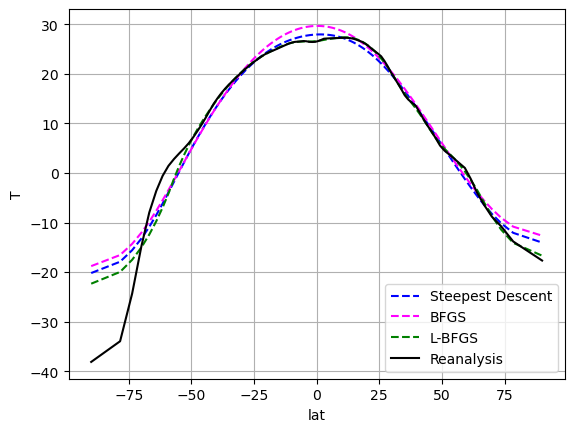

In [76]:

lat = np.arcsin(np.linspace(-1.0, 1.0, N)) * 180.0 / jnp.pi
T_ncep = Ts_annual_interp
plt.plot(lat, T_sd-273,c='blue',ls='--',label='Steepest Descent')
plt.plot(lat, T_bfgs-273,c='magenta',ls='--',label='BFGS')
plt.plot(lat, T_lbfgs-273,c='g',ls='--',label='L-BFGS')
plt.plot(lat,T_ncep,'-k',label='Reanalysis')
plt.legend()
plt.grid()
plt.xlabel('lat')
plt.ylabel('T')

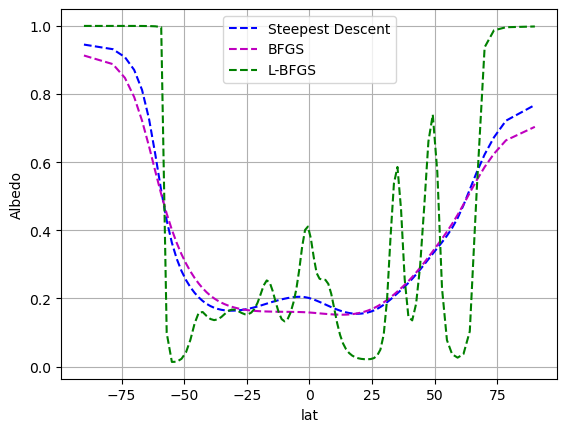

In [77]:
plt.plot(lat,alpha_sd,'--b',label='Steepest Descent')
plt.plot(lat,alpha_bfgs,'--m',label='BFGS')
plt.plot(lat,alpha_lbfgs,'--g',label='L-BFGS')
plt.xlabel('lat')
plt.grid()
plt.ylabel('Albedo')
plt.legend()

Text(0, 0.5, 'Cost function (J)')

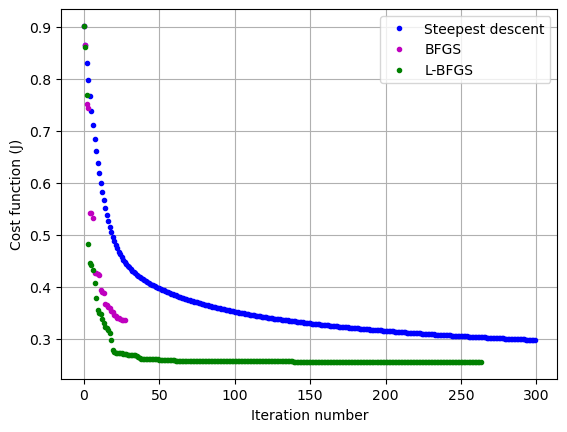

In [79]:
plt.plot(Js_sd,'.b',label='Steepest descent')
plt.plot(J_bfgs,'.m',label='BFGS')
plt.plot(J_lbfgs,'.g',label='L-BFGS')
plt.legend()
#plt.xlim(-1,50)
plt.grid()
plt.xlabel('Iteration number')
plt.ylabel('Cost function (J)')